# INPUT

In [6]:
path_src = '../../src/'

# Libraries
%run -i {path_src}raw_import.py


In [9]:
############################
# Imports...
############################
path_src = '../../src/'

# Libraries
%run -i {path_src}raw_import.py

# Parameters generic
%run -i {path_src}classes/parameters/generic/class_prm_eco.py
%run -i {path_src}classes/parameters/generic/class_prm_tech.py

# Parameters specific
%run -i {path_src}classes/parameters/specific/class_prm_dispatchable.py
%run -i {path_src}classes/parameters/specific/class_prm_fatal.py
%run -i {path_src}classes/parameters/specific/class_prm_storage.py

# Technologies
%run -i {path_src}/classes/class_technos.py

opt_model = cpx.Model(name="cineaste model")

############################
# Economic parameters
############################

#To adapt as i list
r = 0.04
# [TO REDO]
cost_co2 = 50 # [€/t]
demand_growth = 0.01 # %/year

############################
# Time data
############################

# 52 weeks are concatened into small number of weeks in order to speed up the code execution
# Demand is rescale in order to get total annual demand similar
# 'average' groups weeks in a homogeneous way
# 'maxmin' use max demand week as week #1, min demand week as week #2 and random for others

number_of_mean_weeks = 4
profil_weeks = 'maxmin' # choices : 'average' - 'maxmin'
end_of_scenario = 2050

years = range(2020, end_of_scenario +1)
weeks = range(1, number_of_mean_weeks +1)
hours = range(1, 24*7 +1)

U = np.arange(0, 8760, 1)

############################
# demand
############################

# Get exactly 52 weeks... Remove last elements.
demand = np.loadtxt('../../../data/formatted/demand/2019.inc')[:int(7*24*52)]
# Build dataframe with matrix form
demand_reshape = pd.DataFrame(np.array(demand).reshape(-1, 7 * 24))
# compute the total demand in the year
demand_total = demand_reshape.values.sum()

if profil_weeks == 'average':
    # Average by grouping according to number_of_mean_weeks
    demand_average = demand_reshape.groupby(np.arange(len(demand_reshape)) // (52 / number_of_mean_weeks)).mean()
elif profil_weeks == 'maxmin':
    # Find the row with maximum demand
    max_row_index = demand_reshape.idxmax().iloc[0]
    max_row = demand_reshape.loc[[max_row_index]]
    # Find the row with minimum demand
    min_row_index = demand_reshape.idxmin().iloc[0]
    min_row = demand_reshape.loc[[min_row_index]]    
    # Select random rows 
    random_rows_indices = np.random.choice(demand_reshape.index, size=number_of_mean_weeks-2, replace=False)
    random_rows = demand_reshape.loc[random_rows_indices]
    # Concatenate all selected rows into a new DataFrame
    demand_average = pd.concat([max_row, min_row, random_rows])
    demand_average.reset_index(drop=True, inplace=True)
else:
    print('ERROR : Possible choices for profil_weeks... ')
    print('- average')
    print('- maxmin')
    print('Current choice is : ',profil_weeks)

# Calculate total of demand average
demand_average_total = demand_average.values.sum()
# Rescale demand_average in order to have the same energy production
demand_average = demand_average * demand_total / (demand_average_total * 52/number_of_mean_weeks)
# Iterate over the DataFrame and populate the dictionary demand
demand_dict = {(y,w,h): demand_average.iloc[w-1, h-1]*(1+demand_growth)**(y-years[0]) for y in years for w in weeks for h in hours}

############################
# production
############################

techno = {} # dict of output for each year : techno_d[index] => techno dispatchable

#---------------------------
# Dispatchable
#---------------------------

index = 1

nuclear_hist_lifetime = 40 # either 40, 50 or 60
%run -i nuclear/historic.py

%run -i nuclear/new.py
%run -i gas/ccgt.py

#---------------------------
# REN
#---------------------------

%run -i ren/won.py
%run -i ren/wof.py
%run -i ren/pv.py

#---------------------------
# Hydro lake and ROR
#---------------------------

%run -i hydro/ror.py
%run -i hydro/lake.py

#---------------------------
# Storage
#---------------------------

# %run -i inp/test_1/hydro/step.py

#---------------------------
# All
#---------------------------

year = 2020

fig = go.Figure()
for t in techno.keys():
    n = techno[t].get_name() + ' ' + techno[t].get_title()
    # print(techno_d[tec].get_type())
    fig.add_trace(go.Scatter(x=U,y=techno[t].get_eco().get_cost_profile(),line=dict(width=2.0,shape='hv'),mode='lines',name=n))

fig.update_layout(title="année : " + str(year),yaxis_title='Total Cost [€/MW/y]',xaxis_title="Use (h/y)",
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
fig.show()
print()

fig = go.Figure()
for index, row in demand_average.iterrows():
    fig.add_trace(go.Scatter(x=demand_average.columns,y=row,mode='lines',name=f'week {index}'))
    
fig.update_layout(title="année : " + str(year),yaxis_title='Demand (MW)',xaxis_title=f"hour for {number_of_mean_weeks} weeks",
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))

fig.show()   


SyntaxError: EOL while scanning string literal (1115872509.py, line 57)

# Plotting the cost curves

# Model declaration and resoluton

### Avec Gestion Stock (STEP, etc.)

In [ ]:
opt_model.clear()

max_P = max(dict_demand.values())

############################################################################
# Variables
############################################################################

# Installed capacity
var_P = {(i, y): opt_model.continuous_var(name=f'var_P_{i}_{y}', lb=0, ub=max_P)
         for i in techno.keys() for y in years
        }

# Energy produced by all
var_E = {(i, y, h): opt_model.continuous_var(name=f'var_E_{i}_{y}_{h}', lb=0, ub=max_P)
         for i in techno.keys() for y in years for h in hours
        }

# # Energy compress by storage
# var_EC = {(i, y, h): opt_model.continuous_var(name=f'var_EC_{i}_{y}_{h}', lb=0, ub=max_P)
#           for i in techno.keys() if techno[i].get_type() == "storage"
#           for y in years for h in hours
#          }
# 
# # Storage Level
# var_SL = {(i, y, h): opt_model.continuous_var(name=f'var_SL_{i}_{y}_{h}', lb=0, ub=500e3)
#           for i in techno.keys() if techno[i].get_type() == "storage"
#           for y in years for h in hours
#          }

############################################################################
# Constraints
############################################################################

# ----------------------------------------------
# Calibration t <= 2024
# ----------------------------------------------

# # New nuclear
# var_P[2,2020] = var_P[2,2022] = var_P[2,2023] = var_P[2,2024] = 0
# # => ADD FLA3
# 
# # CCGT
# var_P[3,2020] = var_P[3,2021] = var_P[3,2022] = var_P[3,2023] = var_P[3,2024] = 18.54e3
# 
# # WON
# var_P[4,2020] = 17e3
# var_P[4,2021] = 18e3
# var_P[4,2022] = 19e3
# var_P[4,2023] = 20e3
# 
# # WOF
# 
# var_P[5,2020] = var_P[5,2021] = 0
# var_P[5,2022] = 0.500e3
# 
# # PV
# var_P[6,2020] = 9e3
# var_P[6,2021] = 10.5e3
# var_P[6,2022] = 13e3
# var_P[6,2023] = 15.5e3

# ----------------------------------------------
# Sum_{tec} (supply (tec,y,h)) >= Demand (y,t)
# >= or == according to curtailment
# ----------------------------------------------

# Precompute sum values for each (y, h) combination
sum_var_E  = {(y, h): opt_model.sum(var_E[i, y, h] for i in techno.keys()) for y in years for h in hours}
#sum_var_EC = {(y, h): opt_model.sum(var_EC[i, y, h] for i in techno.keys()  if techno[i].get_type() == "storage") for y in years for h in hours}

# sum_t[var_ED(t,y,h) + var_EF(t,y,h) + var_ES(t,y,h) = Demand(y,h)]
for y in years:
    for h in hours:
#        opt_model.add_constraint(ct = sum_var_E[y,h] == dict_demand[y,h] + sum_var_EC[y,h])
        opt_model.add_constraint(ct = sum_var_E[y,h] == dict_demand[y,h])

# ----------------------------------------------
# sum(P) >= max demand
# ----------------------------------------------

for y in years:
    max_P_y = max(dict_demand[y, h] for h in hours)
    opt_model.add_constraint(ct = opt_model.sum( var_P[i,y] for i in techno.keys() ) >= max_P_y )

# ----------------------------------------------
# All
# i => index
# t => Techno[i]
# tec  => Techno[i].get_tech()
# eco  => Techno[i].get_eco()
# spec => Techno[i].get_spec()
# ----------------------------------------------

for i,t in techno.items():
    is_fatal   = (t.get_type() == 'fatal')
    is_storage = (t.get_type() == 'storage')
    tec  = t.get_tech()
    eco  = t.get_eco()
    spec = t.get_spec()
    is_P_var = tec.get_isPvar()
    is_E_var = tec.get_isEvar()
    P = tec.get_P()
    E = tec.get_E()
#    if is_storage:
#        EC = spec.get_EC()
#        SL = spec.get_level()
#        # ----------------------------------------------
#        # Initialize storage at BOS
#        # ----------------------------------------------
#        opt_model.add_constraint(ct = var_SL[i,years[0],hours[0]] == spec.get_level_start())
        
    for y in years:
        # ----------------------------------------------
        # E(i,y,h) <= P(i,y) * 1h for each machines
        # ----------------------------------------------
        for h in hours:
            opt_model.add_constraint(ct = var_E[i,y,h] <= var_P[i,y] * 1 )
        # ----------------------------------------------
        # P Exogeneous variable => Fixed
        # ----------------------------------------------
        if not is_P_var[y]:
            opt_model.add_constraint(ct = var_P[i,y] == P[y])
            for h in hours:
                if not is_E_var[y,h]:
                    # ----------------------------------------------
                    # E Exogeneous variable => Fixed
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i,y,h] == E[y,h])
    # ----------------------------------------------
    # Fatal energy : E(i,y,h) = LF(i,y,h) * P(i,y)
    # ----------------------------------------------
    if is_fatal:
        for y in years:
            for h in hours:
                opt_model.add_constraint(ct = var_E[i,y,h] == tec.get_LF()[y,h] * var_P[i,y])
    # ----------------------------------------------
    # Ramping : 
    # ----------------------------------------------
    if not is_fatal and not is_storage:
        rup = spec.get_rup()
        rdo = spec.get_rdo()
        for y in years:
            for h in hours:
                if is_E_var[y,h]:
                    if (h == hours[-1]) and (y != years[-1]):
                        opt_model.add_constraint(ct = var_E[i,y+1,1] <= var_E[i,y,h] + var_P[i,y]*rup)
                        opt_model.add_constraint(ct = var_E[i,y+1,1] >= var_E[i,y,h] - var_P[i,y]*rdo)
                    elif (h == hours[-1]) and (y == years[-1]):
                        pass
                    else:
                        opt_model.add_constraint(ct = var_E[i,y,h+1] <= var_E[i,y,h] + var_P[i,y]*rup)
                        opt_model.add_constraint(ct = var_E[i,y,h+1] >= var_E[i,y,h] - var_P[i,y]*rdo)
# ----------------------------------------------
# E >= 0 if not storage
# ----------------------------------------------    
#    if not is_storage:
#        for y in years:
#            for h in hours:
#                opt_model.add_constraint(ct = var_E[i,y,h] >= 0)
# ----------------------------------------------
# If storage : E <= Stock + condition on E si < 0 ??!!
# ----------------------------------------------

    # ----------------------------------------------
    # Storage : STEP
    # S(y,h) <= level_max
    # S(y,h) >= level_min
    # if E(y,h) >= 0
    #      => E(y,h) <= P(y)
    #      => S(y,h+1) = S(y,h) - E(y,h)
    # if E(y,h) < 0 
    #      => E(y,h) >= -P/eff
    #      => S(y,h+1) = S(y,h) - E(y,h)*eff
    # Efficiency to ADD !!
    # ----------------------------------------------
#    if is_storage:
#        level_max = spec.get_level_max()
#        level_min = spec.get_level_min()
#        for y in years:
#            for h in hours:
#                # E > 0 => EC = 0 and E = 0 => EC >= 0
#                # opt_model.add_constraint(var_E[i,y,h]*var_EC[i,y,h] == 0) => Not linear !!
#                    
#                opt_model.add_constraint(ct = var_SL[i,y,h] <= level_max)
#                opt_model.add_constraint(ct = var_SL[i,y,h] >= level_min)
#
#                if h < hours[-1]:
#                    opt_model.add_constraint(ct = var_SL[i,y,h+1] == var_SL[i,y,h]  - var_E[i,y,h] + var_EC[i,y,h] )
#                elif h == hours[-1] and y < years[-1]:
#                    opt_model.add_constraint(ct = var_SL[i,y+1,1] == var_SL[i,y,h]  - var_E[i,y,h] + var_EC[i,y,h] )
#                else:
#                    pass

######################################
# Obj function + Solve
######################################

# Compute fixed and variable costs
sum_fixed_cost    = {(y): opt_model.sum(var_P[i,y] * techno[i].get_eco().get_fix_tot() for i in techno.keys()) for y in years}

# Here ... Compress is free !! 
sum_variable_cost = {(y,h): opt_model.sum(var_E[i,y,h] * techno[i].get_eco().get_var_tot() for i in techno.keys()) for y in years for h in hours}

# Total cost 
objective = opt_model.sum(sum_fixed_cost[y] for y in years) + opt_model.sum(sum_variable_cost[y,h] for y in years for h in hours)

# Solve
opt_model.minimize(objective)
solution = opt_model.solve()

#print("Solution status:", opt_model.solve_details.status)
#print("Objective value:", opt_model.objective_value)
#print("Time spent in solving:", opt_model.solve_details.time)

######################################
# Store data
######################################
for i,t in techno.items():
    is_fatal   = (t.get_type() == 'fatal')
#    is_storage = (t.get_type() == 'storage')

    P   = {y: var_P[i,y].solution_value for y in years}
    E   = {(y, h): var_E[i,y,h].solution_value for y in years for h in hours}
#    EC  = {(y, h): var_EC[i,y,h].solution_value for y in years for h in hours if is_storage}
#    SL  = {(y, h): var_SL[i,y,h].solution_value for y in years for h in hours if is_storage}

    t.get_tech().set_P(copy.deepcopy(P))
    t.get_tech().set_E(copy.deepcopy(E))
#    if is_storage:
#        t.get_spec().set_EC(copy.deepcopy(EC))
#        t.get_spec().set_level(copy.deepcopy(SL))

fig = go.Figure()
year = 2028

################################################
# Plottling Energy
################################################

for i,t in techno.items():
    name = t.get_name() + ' ' + t.get_title()
    x = [h for y, h in t.get_tech().get_E().keys() if y == year]
    vals = [t.get_tech().get_E()[(year, h)] for h in x]
    fig.add_trace(go.Scatter(x=x,y=vals,stackgroup='one',line=dict(width=0.2),name=name))

x = [h for y, h in dict_demand.keys() if y == year]
vals = [dict_demand[(year, h)] for h in x]
fig.add_trace(go.Scatter(x=x,y=vals,mode='lines',line=dict(width=2.0),opacity=0.50,name='Demand'))

fig.update_layout(title="Parc Optimal - " + str(year),
                  yaxis_title='Production (MWh [1/2h step])',
                  xaxis_title="Time step",
                  #barmode='stack',
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
fig.show()

print()

################################################
# Plotting Storage levels
################################################
# 
# fig = go.Figure()
# 
# for i,t in techno.items():
#     if t.get_type() == 'storage':
#         name = t.get_name() + ' ' + t.get_title()
#         x = [h for y, h in t.get_spec().get_level().keys() if y == year]
#         vals = [t.get_spec().get_level()[(year, h)] for h in x]
#         fig.add_trace(go.Scatter(x=x,y=vals,stackgroup='one',line=dict(width=0.2),name=name))
# 
# fig.update_layout(title="Storage Level",
#                   yaxis_title='MWh',
#                   xaxis_title="",
#                   #barmode='stack',
#                   width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
# fig.show()
# 
# print()
# 
################################################
# Plotting Capacity evolution
################################################

fig = go.Figure()

for i,t in techno.items():
    name = t.get_name() + ' ' + t.get_title()
    x    = list(t.get_tech().get_P().keys())
    vals = list(t.get_tech().get_P().values())
    fig.add_trace(go.Scatter(x=x,y=vals,mode='lines',line=dict(width=2.0),name=name))

fig.update_layout(title="Capacity",
                  yaxis_title='MW',
                  xaxis_title="",
                  #barmode='stack',
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
fig.show()


### Sans gestion Stock (Simple)

In [2]:
opt_model.clear()

max_P = max(demand_dict.values())

############################################################################
# Variables
############################################################################

# Installed capacity
var_P = {(i, y): opt_model.continuous_var(name=f'var_P_{i}_{y}', lb=0, ub=max_P)
         for i in techno.keys() for y in years
        }

# Energy produced by all
var_E = {(i,y,w,h): opt_model.continuous_var(name=f'var_E_{i}_{y}_{w}_{h}', lb=0, ub=max_P)
         for i in techno.keys() for y in years for w in weeks for h in hours
        }

############################################################################
# Constraints
############################################################################

# ----------------------------------------------
# Calibration t <= 2024
# ----------------------------------------------

# New nuclear
# opt_model.add_constraint(ct = var_P[2,2020] == 0)
# opt_model.add_constraint(ct = var_P[2,2021] == 0)
# opt_model.add_constraint(ct = var_P[2,2022] == 0)
# opt_model.add_constraint(ct = var_P[2,2023] == 0)
# opt_model.add_constraint(ct = var_P[2,2024] == 1.650e3) # FLA3

# CCGT
# opt_model.add_constraint(ct = var_P[3,2020] == 18.54e3)
# opt_model.add_constraint(ct = var_P[3,2021] == 18.54e3)
# opt_model.add_constraint(ct = var_P[3,2022] == 18.54e3)
# opt_model.add_constraint(ct = var_P[3,2023] == 18.54e3)
# opt_model.add_constraint(ct = var_P[3,2024] == 18.54e3)

# WON
# opt_model.add_constraint(ct = var_P[4,2020] == 17e3)
# opt_model.add_constraint(ct = var_P[4,2021] == 18e3)
# opt_model.add_constraint(ct = var_P[4,2022] == 19e3)
# opt_model.add_constraint(ct = var_P[4,2023] == 20e3)
# 
# # WOF
# opt_model.add_constraint(ct = var_P[5,2020] == 0)
# opt_model.add_constraint(ct = var_P[5,2021] == 0)
# opt_model.add_constraint(ct = var_P[5,2022] == 0.5e3)
# opt_model.add_constraint(ct = var_P[5,2023] == 0.5e3)
# 
# # PV
# opt_model.add_constraint(ct = var_P[6,2020] == 9e3)
# opt_model.add_constraint(ct = var_P[6,2021] == 10.5e3)
# opt_model.add_constraint(ct = var_P[6,2022] == 13e3)
# opt_model.add_constraint(ct = var_P[6,2023] == 15.5e3)
                                                  
# ----------------------------------------------
# Sum_{tec} (supply (tec,y,h)) >= Demand (y,t)
# >= or == according to curtailment
# ----------------------------------------------

# Precompute sum values for each (y,w,h) combination
sum_var_E  = {(y,w,h): opt_model.sum(var_E[i,y,w,h] for i in techno.keys()) for y in years for w in weeks for h in hours}

for y in years:
    # ----------------------------------------------
    # sum(P) >= max demand
    # ----------------------------------------------
    max_P_y = max(demand_dict[y,w,h] for w in weeks for h in hours)
    opt_model.add_constraint(ct = opt_model.sum( var_P[i,y] for i in techno.keys() ) >= max_P_y )
    for w in weeks:
        for h in hours:
            # ----------------------------------------------
            # sum_t[var_E(t,y,h)] = Demand(y,h)]
            # ----------------------------------------------
            opt_model.add_constraint(ct = sum_var_E[y,w,h] == demand_dict[y,w,h])

# ----------------------------------------------
# All
# i => index
# t => Techno[i]
# tec  => Techno[i].get_tech()
# eco  => Techno[i].get_eco()
# spec => Techno[i].get_spec()
# ----------------------------------------------

for i,t in techno.items():
    is_fatal   = (t.get_type() == 'fatal')
    tec  = t.get_tech()
    eco  = t.get_eco()
    spec = t.get_spec()
    is_P_var = tec.get_isPvar()
    is_E_var = tec.get_isEvar()
    P = tec.get_P()
    E = tec.get_E()
        
    for y in years:
        if not is_P_var[y]:
            # ----------------------------------------------
            # P Exogeneous variable => Fixed
            # ----------------------------------------------
            opt_model.add_constraint(ct = var_P[i,y] == P[y])

    for y in years:
        for w in weeks:
            for h in hours:
                # ----------------------------------------------
                # E(i,y,h) <= P(i,y) * 1h for each machines
                # ----------------------------------------------
                opt_model.add_constraint(ct = var_E[i,y,w,h] <= var_P[i,y] * 1 )
                
            for h in hours:
                if not is_E_var[y,w,h]:
                    # ----------------------------------------------
                    # E Exogeneous variable => Fixed
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i,y,w,h] == E[y,w,h])
    if is_fatal:
        for y in years:
            for w in weeks:
                for h in hours:
                    # ----------------------------------------------
                    # Fatal energy : E(i,y,h) = LF(i,y,h) * P(i,y)
                    # ----------------------------------------------
                    opt_model.add_constraint(ct = var_E[i,y,w,h] == tec.get_LF()[y,w,h] * var_P[i,y])
    # ----------------------------------------------
    # Ramping : Energy
    # ----------------------------------------------
#    if not is_fatal:
#        rup = spec.get_rup()
#        rdo = spec.get_rdo()
#        for y in years:
#            for h in hours:
#                if is_E_var[y,h]:
#                    if (h == hours[-1]) and (y != years[-1]):
#                        opt_model.add_constraint(ct = var_E[i,y+1,1] <= var_E[i,y,h] + var_P[i,y]*rup)
#                        opt_model.add_constraint(ct = var_E[i,y+1,1] >= var_E[i,y,h] - var_P[i,y]*rdo)
#                    elif (h == hours[-1]) and (y == years[-1]):
#                        pass
#                    else:
#                        opt_model.add_constraint(ct = var_E[i,y,h+1] <= var_E[i,y,h] + var_P[i,y]*rup)
#                        opt_model.add_constraint(ct = var_E[i,y,h+1] >= var_E[i,y,h] - var_P[i,y]*rdo)
#    
    # ----------------------------------------------
    # Ramping : Capa
    # ----------------------------------------------


######################################
# Obj function + Solve
######################################

# Compute fixed and variable costs
sum_fixed_cost    = {(y): opt_model.sum(var_P[i,y] * techno[i].get_eco().get_fix_tot() for i in techno.keys()) for y in years}

# Here ... Compress is free !! 
sum_variable_cost = {(y,w,h): opt_model.sum(var_E[i,y,w,h] * techno[i].get_eco().get_var_tot()*(365/7/number_of_mean_weeks) for i in techno.keys()) for y in years for w in weeks for h in hours}

# Total cost 
objective = opt_model.sum(sum_fixed_cost[y] for y in years) + opt_model.sum(sum_variable_cost[y,w,h] for y in years for w in weeks for h in hours)
#objective = opt_model.sum(sum_fixed_cost[y]/(1+r)**y for y in years) + opt_model.sum(sum_variable_cost[y,h]/(1+r)**y for y in years for h in hours)

# Solve
opt_model.minimize(objective)
solution = opt_model.solve()

#print("Solution status:", opt_model.solve_details.status)
#print("Objective value:", opt_model.objective_value)
#print("Time spent in solving:", opt_model.solve_details.time)

######################################
# Store data
######################################
for i,t in techno.items():
    P   = {y: var_P[i,y].solution_value for y in years}
    E   = {(y,w,h): var_E[i,y,w,h].solution_value for y in years for w in weeks for h in hours}
    t.get_tech().set_P(copy.deepcopy(P))
    t.get_tech().set_E(copy.deepcopy(E))


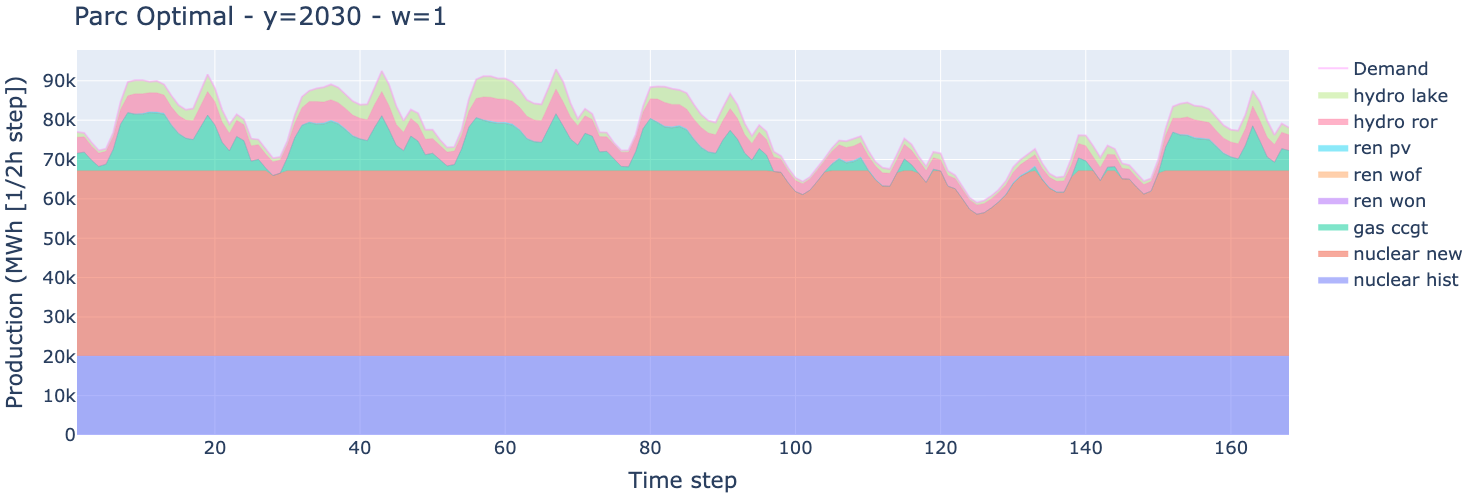

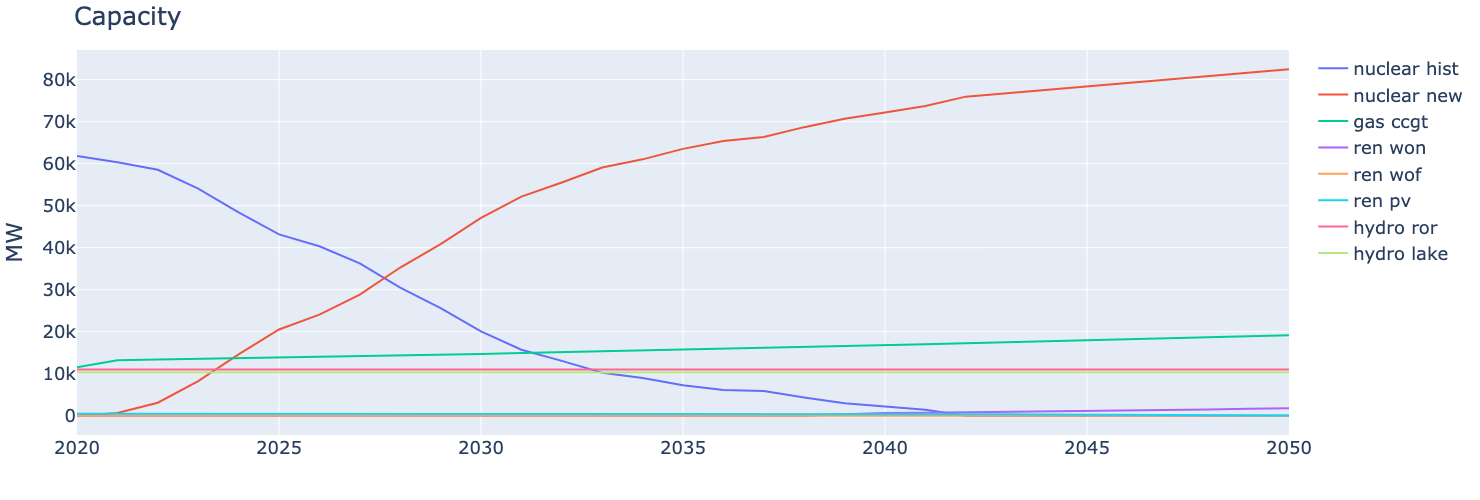

In [3]:
################################################
# Plotting Energy 
################################################

fig = go.Figure()
year = 2030
week = 1

for i,t in techno.items():
    name = t.get_name() + ' ' + t.get_title()
    x = [h for y,w,h in t.get_tech().get_E().keys() if y == year and w == week]
    vals = [t.get_tech().get_E()[(year,week,h)] for h in x]
    fig.add_trace(go.Scatter(x=x,y=vals,stackgroup='one',line=dict(width=0.2),name=name))

x = [h for y,w,h in demand_dict.keys() if y == year and w == week]
vals = [demand_dict [(year,week,h)] for h in x]
fig.add_trace(go.Scatter(x=x,y=vals,mode='lines',line=dict(width=2.0),opacity=0.50,name='Demand'))

fig.update_layout(title=f"Parc Optimal - y={year} - w={week}",
                  yaxis_title='Production (MWh [1/2h step])',
                  xaxis_title="Time step",
                  #barmode='stack',
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
fig.show()

print()

################################################
# Capacity evolution
################################################

fig = go.Figure()

for i,t in techno.items():
    name = t.get_name() + ' ' + t.get_title()
    x    = list(t.get_tech().get_P().keys())
    vals = list(t.get_tech().get_P().values())
    fig.add_trace(go.Scatter(x=x,y=vals,mode='lines',line=dict(width=2.0),name=name))

fig.update_layout(title="Capacity",
                  yaxis_title='MW',
                  xaxis_title="",
                  #barmode='stack',
                  width=1000,height=500,margin=dict(l=50,r=150,b=30,t=50),font=dict(size=18))
fig.show()


# OLD

In [ ]:
#for year in tqdm(range(start_year, start_year + 3), desc="Processing Years"):
for year in tqdm(range(start_year, stop_year+1), desc="Processing Years"):    
    
    opt_model.clear()

    # Convert list to dict for CPLEX
    dict_demand = {index: value for index, value in enumerate(data_demand[year])}

    ######################################
    # Variables
    ######################################

    var_P = {} # Capacity
    var_E = {} # Energy
    var_C = {} # Curtailment

    for tec in techno_d[year]:
        var_P[tec.get_id()] = opt_model.continuous_var(     lb = 0, ub = max(data_demand[year]), name = 'P_' + str(tec.get_id()))
        var_E[tec.get_id()] = {t: opt_model.continuous_var( lb = 0, ub = max(data_demand[year]), name = 'E_' + str(tec.get_id()) + '_' + str(t) ) for t in set_time_year}
        # Curtailment
        var_C[tec.get_id()] = {t: opt_model.continuous_var( lb = 0, ub = max(data_demand[year]), name = 'C_' + str(tec.get_id()) + '_' + str(t) ) for t in set_time_year}

    ######################################
    # Constraints 
    ######################################

    # Exogeneous variable => Fix
    for tec in techno_d[year]:
        if tec.get_prm_tech().get_isPvar() == False:
            opt_model.add_constraint(ct = var_P[tec.get_id()] == tec.get_prm_tech().get_P())
        if tec.get_prm_tech().get_isEvar() == False:
            for t in set_time_year:
                opt_model.add_constraint(ct = var_E[tec.get_id()][t] == tec.get_prm_tech().get_E()[t])

    # Fatal energy : E(t) = LF(t) * P
    for tec in techno_d[year]:
        if tec.get_prm_tech().get_isFatal() == True:
            for t in set_time_year:
                opt_model.add_constraint(ct = var_E[tec.get_id()][t] == tec.get_prm_tech().get_LF()[t] * var_P[tec.get_id()])

    # Supply (t) >= Demand (t)
    for t in set_time_year:
        opt_model.add_constraint(ct = opt_model.sum(var_E[tec.get_id()][t] for tec in techno_d[year] ) >= dict_demand[t])

    # Curtailment
    for t in set_time_year:
        opt_model.add_constraint(ct = opt_model.sum(var_C[tec.get_id()][t] for tec in techno_d[year] ) == 
                                      opt_model.sum(var_E[tec.get_id()][t] for tec in techno_d[year] ) - dict_demand[t])
        
    # E <= P * 1h for each machines
    for tec in techno_d[year]:
        if tec.get_prm_tech().get_isEvar():
            for t in set_time_year:
                opt_model.add_constraint(ct = var_E[tec.get_id()][t] <= var_P[tec.get_id()])

    # sum(P) >= max demand
    opt_model.add_constraint(ct = opt_model.sum( var_P[tec.get_id()] for tec in techno_d[year] ) >= max(data_demand[year]))

    # Autres contraintes ... ? 

    ######################################
    # Obj function + Solve + store
    ######################################

    # Total cost 
    objective = opt_model.sum( tec.get_prm_eco().get_fix_tot()   * var_P[tec.get_id()] + 
                               (tec.get_prm_eco().get_var_tot()) * opt_model.sum(var_E[tec.get_id()][t] for t in set_time_year)
                               for tec in techno_d[year]
                             )

    # Solve
    opt_model.minimize(objective)
    solution = opt_model.solve()

#print("Solution status:", opt_model.solve_details.status)
#print("Objective value:", opt_model.objective_value)
#print("Time spent in solving:", opt_model.solve_details.time)


    for tec in techno_d[year]:
        E = []
        C = []
        tec.get_prm_tech().set_P(var_P[tec.get_id()].solution_value)
        for t in set_time_year:
            E.append(var_E[tec.get_id()][t].solution_value)
            C.append(var_C[tec.get_id()][t].solution_value)
        tec.get_prm_tech().set_E(E)
        tec.get_prm_tech().set_C(C)


In [ ]:
opt_model.clear()

######################################
# Variables
######################################

#var_P = {} # Capacity : var_P[tec,y]
#var_E = {} # Energy : var_E[tec,y,h]
#var_C = {} # Curtailment : var_C[tec,y,h]
#var_SE = {} # Stock 
#var_SL = {} # Stock 

max_P = max(dict_demand.values())
            
# Capacity
var_P = {(r, t, y): opt_model.continuous_var(name=f'var_P_{tec}_{y}', lb=0, ub=max_P)
         for r in techno.keys()
             for t in techno[r].keys()
                 for y in years}

# Dispatcheable Energy
var_E = {(tec, y, h): opt_model.continuous_var(name=f'var_E_{tec}_{y}_{h}', lb=0, ub=max_P)
                      for tec in techno_d.keys()
                      if techno_d[tec].get_prm_tech().is_storage() == False
                      for y in years for h in hours}

# Storage Energy
var_SE = {(tec, y, h): opt_model.continuous_var(name=f'var_SE_{tec}_{y}_{h}', lb=-max_P, ub=max_P)
                       for tec in techno_d.keys()
                       if techno_d[tec].get_prm_tech().is_storage() == True
                       for y in years for h in hours}

# Storage Level
var_SL = {(tec, y, h): opt_model.continuous_var(name=f'var_SL_{tec}_{y}_{h}', lb=0, ub=500e3)
                       for tec in techno_d.keys() 
                       if techno_d[tec].get_prm_tech().is_storage() == True
                       for y in years 
                       for h in hours}

######################################
# Constraints 
######################################

# ----------------------------------------------
# Sum_{tec} (supply (tec,y,h)) >= Demand (y,t)
# ----------------------------------------------

# Precompute sum values for each (y, h) combination
sum_var_E = {(y, h):(
                    opt_model.sum(var_E[tec, y, h]
                        for tec in techno_d.keys()
                            if not techno_d[tec].get_prm_tech().is_storage())
                    +
                    opt_model.sum(var_SE[tec, y, h]
                        for tec in techno_d.keys()
                            if techno_d[tec].get_prm_tech().is_storage())
                    )
                    for y in years for h in hours 
}



# ----------------------------------------------
# Exogeneous variable => Fixed
# ----------------------------------------------

for tec in techno_d.keys():
        for y in years:
            if not techno_d[tec].get_prm_tech().get_isPvar()[y]:
                opt_model.add_constraint(ct = var_P[tec,y] == techno_d[tec].get_prm_tech().get_P()[y])
                for h in hours:
                    if not techno_d[tec].get_prm_tech().get_isEvar()[y,h]:
                        opt_model.add_constraint(ct = var_E[tec,y,h] == techno_d[tec].get_prm_tech().get_E()[y,h])
    

# ----------------------------------------------
# Ramping : 
# ----------------------------------------------

for tec in techno_d.keys():
    if not techno_d[tec].get_prm_tech().get_isFatal() and not techno_d[tec].get_prm_tech().is_storage():
        for y in years:
            for h in hours[:-1]:
                if techno_d[tec].get_prm_tech().get_isEvar()[y,h]:
                    _rup = techno_d[tec].get_prm_tech().get_rup()
                    _rdo = techno_d[tec].get_prm_tech().get_rdo()
                    opt_model.add_constraint(ct = var_E[tec,y,h+1] <= var_E[tec,y,h] + var_P[tec,y]*_rup)
                    opt_model.add_constraint(ct = var_E[tec,y,h+1] >= var_E[tec,y,h] - var_P[tec,y]*_rdo)

# ----------------------------------------------
# E <= P * 1h for each machines
# ----------------------------------------------

#for tec in techno_d.keys():
#        if techno_d[tec].get_prm_tech().get_isEvar():
#            for y, h in zip(years, hours):
#                opt_model.add_constraint(ct = var_E[tec,y,h] <= var_P[tec,y])

# ----------------------------------------------
# E >= 0 if not storage
# ----------------------------------------------

#for tec in techno_d.keys():
#    if not techno_d[tec].get_prm_tech().is_storage():
#        if techno_d[tec].get_prm_tech().get_isEvar():
#            for y in years:
#                for h in hours:
#                    opt_model.add_constraint(ct = var_E[tec,y,h] >= 0)

# ----------------------------------------------
# E >= -P if storage pumping
# ----------------------------------------------

#for tec in techno_d.keys():
#    if techno_d[tec].get_prm_tech().is_storage():
#        if techno_d[tec].get_prm_tech().get_isEvar():
#            for y in years:
#                for h in hours:
#                    opt_model.add_constraint(ct = var_SE[tec,y,h] >= -var_P[tec,y])
                    
# ----------------------------------------------
# Storage : STEP
# S(y,h) <= level_max
# S(y,h) >= level_min
# if E(y,h) >= 0
#      => E(y,h) <= P(y)
#      => S(y,h+1) = S(y,h) - E(y,h)
# if E(y,h) < 0 
#      => E(y,h) >= -P/eff
#      => S(y,h+1) = S(y,h) - E(y,h)*eff
# Efficiency to ADD !!
# ----------------------------------------------

for tec in techno_d.keys():
    if techno_d[tec].get_prm_tech().is_storage():
        for y in years:
            for h in hours:
                opt_model.add_constraint(ct = var_SL[tec,y,h] <= techno_d[tec].get_prm_tech().get_level_max())
                opt_model.add_constraint(ct = var_SL[tec,y,h] >= techno_d[tec].get_prm_tech().get_level_min())
                if (y == years[0] and h == 1):
                    opt_model.add_constraint(ct = var_SL[tec,y,h] == techno_d[tec].get_prm_tech().get_level_start())
                elif (y != years[0] and h == 1):
                    opt_model.add_constraint(ct = var_SL[tec,y,h] == var_SL[tec,y-1,hours[-1]])
                elif (h < hours[-1]):
                    opt_model.add_constraint(ct = var_SL[tec,y,h+1] == var_SL[tec,y,h] - var_SE[tec,y,h])
                else:
                    print(tec,y,h)

# ----------------------------------------------
# Storage : Lake
# ----------------------------------------------



